In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images
! unzip alzheimers-dataset-4-class-of-images.zip

In [3]:
import os
import shutil

sourceTrain = ['/content/Alzheimer_s Dataset/train/ModerateDemented', '/content/Alzheimer_s Dataset/train/MildDemented']
destinationTrain = '/content/Alzheimer_s Dataset/train/VeryMildDemented'

sourceTest = ['/content/Alzheimer_s Dataset/test/ModerateDemented', '/content/Alzheimer_s Dataset/test/MildDemented']
destinationTest = '/content/Alzheimer_s Dataset/test/VeryMildDemented'


for source in sourceTrain:

  allfiles = os.listdir(source)

  for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destinationTrain, f)
    shutil.move(src_path, dst_path)



for source in sourceTest:

  allfiles = os.listdir(source)

  for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destinationTest, f)
    shutil.move(src_path, dst_path)

import os

old_name_test = r"/content/Alzheimer_s Dataset/test/VeryMildDemented"
new_name_test = r"/content/Alzheimer_s Dataset/test/Demented"
old_name_train = r"/content/Alzheimer_s Dataset/train/VeryMildDemented"
new_name_train = r"/content/Alzheimer_s Dataset/train/Demented"
os.rename(old_name_train, new_name_train)
os.rename(old_name_test, new_name_test)

%rmdir '/content/Alzheimer_s Dataset/test/MildDemented'
%rmdir '/content/Alzheimer_s Dataset/test/ModerateDemented'
%rmdir '/content/Alzheimer_s Dataset/train/MildDemented'
%rmdir '/content/Alzheimer_s Dataset/train/ModerateDemented'

In [4]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from tqdm import tqdm
%matplotlib inline

In [5]:
def create_ref_df(dataset_path):
    """
    Create a reference dataframe with the following columns:
    - path: path to the image
    - label: label of the image
    """
    paths, labels = [], []

    for folder in os.listdir(dataset_path):
        for file in os.listdir(os.path.join(dataset_path, folder)):

            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)

    ref_df = pd.DataFrame({
        'path': paths,
        'label': labels
    })

    ref_df = ref_df.astype({
        'path': 'string',
        'label': 'string',
    })

    return ref_df

In [6]:

def load_images(ref_df):
    labels = []
    images = []
    paths = []

    # to only load a subset of images
    # ref_df = ref_df.sample(n=100)
    for idx, row in tqdm(ref_df.iterrows(), total=ref_df.shape[0]):
        images.append(np.array(Image.open(row['path']).convert('L')))
        labels.append(row['label'])
        paths.append(row['path'])

    return images, labels, paths

In [7]:
def get_image_stats(images, labels, paths):
    means, stds, widths, heights = [], [], [], []
    skewnesses = []

    for image in tqdm(images):
        means.append(np.mean(image))
        stds.append(np.std(image))
        widths.append(image.shape[0])
        heights.append(image.shape[1])
        image_hist = np.histogram(image.flatten())[0]
        skewnesses.append(skew(image_hist))

    image_stats = pd.DataFrame({
        'mean': means,
        'std': stds,
        'width': widths,
        'height': heights,
        'skew': skewnesses
    })

    image_stats['label'] = labels
    image_stats['path'] = paths
    return image_stats

In [8]:
ref_df = create_ref_df('/content/Alzheimer_s Dataset/train')

In [9]:
ref_df.head()

,path,label
0,/content/Alzheimer_s Dataset/train/NonDemented...,NonDemented
1,/content/Alzheimer_s Dataset/train/NonDemented...,NonDemented
2,/content/Alzheimer_s Dataset/train/NonDemented...,NonDemented
3,/content/Alzheimer_s Dataset/train/NonDemented...,NonDemented
4,/content/Alzheimer_s Dataset/train/NonDemented...,NonDemented


In [10]:
images, labels, paths = load_images(ref_df)

100%|██████████| 5121/5121 [00:02<00:00, 1793.02it/s]


In [11]:
image_stats = get_image_stats(images, labels, paths)

100%|██████████| 5121/5121 [00:17<00:00, 294.53it/s]


In [12]:
image_stats.describe()

,mean,std,width,height,skew
count,5121.000000,5121.000000,5121.0,5121.0,5121.000000
mean,71.942694,82.510005,208.0,176.0,2.521871
std,7.015129,6.700815,0.0,0.0,0.077611
min,33.747705,44.124500,208.0,176.0,1.905248
25%,68.108446,80.210796,208.0,176.0,2.489972
50%,72.499181,83.611885,208.0,176.0,2.542479
75%,77.000874,86.801109,208.0,176.0,2.571449
max,87.268466,97.711499,208.0,176.0,2.656418


<Axes: xlabel='label', ylabel='Count'>

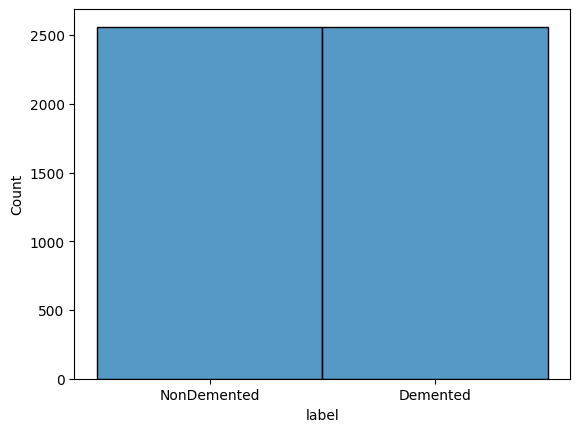

In [13]:
sns.histplot(ref_df, x='label')

<Axes: xlabel='mean', ylabel='std'>

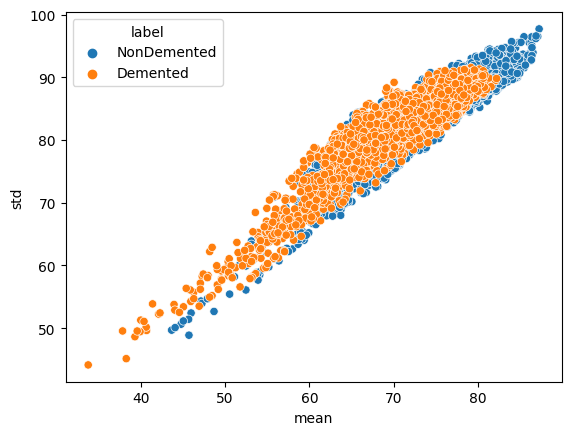

In [14]:
sns.scatterplot(image_stats, x='mean', y='std', hue = 'label')

<Axes: xlabel='mean', ylabel='skew'>

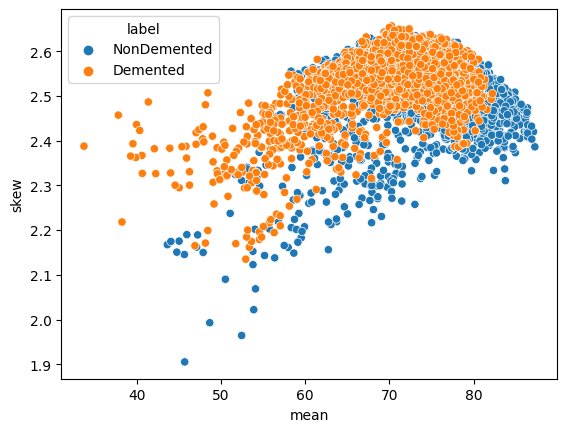

In [15]:
sns.scatterplot(image_stats, x='mean', y='skew', hue='label')

<Axes: xlabel='std', ylabel='skew'>

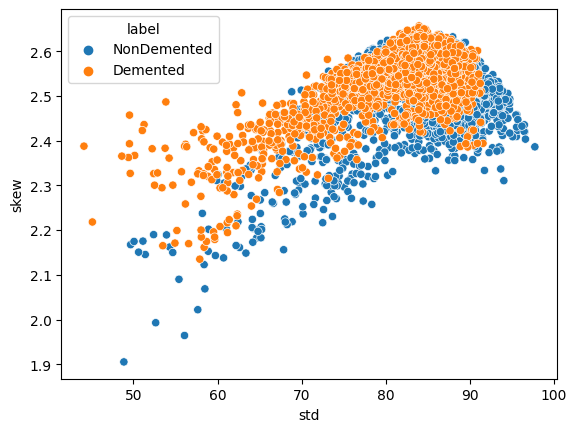

In [16]:
sns.scatterplot(image_stats, x='std', y='skew', hue='label')

In [17]:
dist = ref_df['label'].value_counts(normalize=True)
dist = dist.reset_index()
dist.columns = ['label', 'percentage']
dist['percentage'] = dist['percentage']*100
dist = dist.sort_values(by='label')

sampled_image_stats = pd.DataFrame()
for label in dist['label'].unique():
    sampled_image_stats = pd.concat([sampled_image_stats, image_stats[ref_df['label'] == label].sample(n=100, random_state=42)])

sampled_image_stats = sampled_image_stats.reset_index(drop=True)

In [18]:
px.scatter_3d(sampled_image_stats, x='mean', y='std', z='skew', color='label', title='3D Scatter Plot of Image Statistics')

<Axes: xlabel='label', ylabel='mean'>

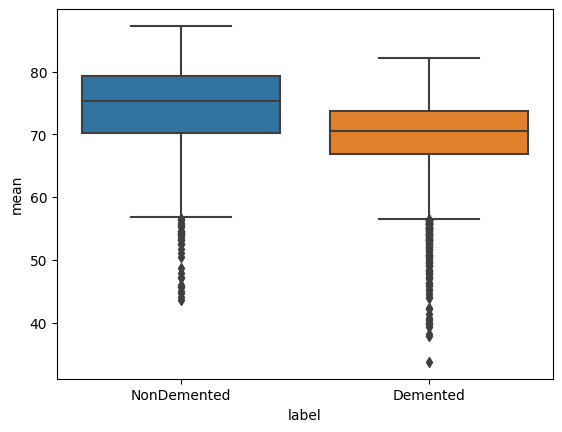

In [19]:
sns.boxplot(image_stats, y='mean', x='label')


<Axes: xlabel='label', ylabel='std'>

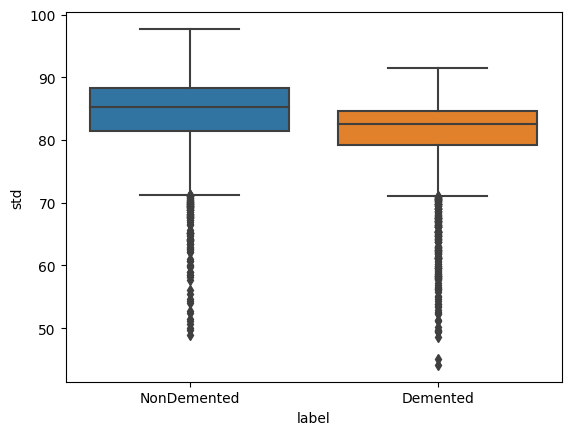

In [20]:
sns.boxplot(image_stats, y='std', x='label')


<Axes: xlabel='label', ylabel='skew'>

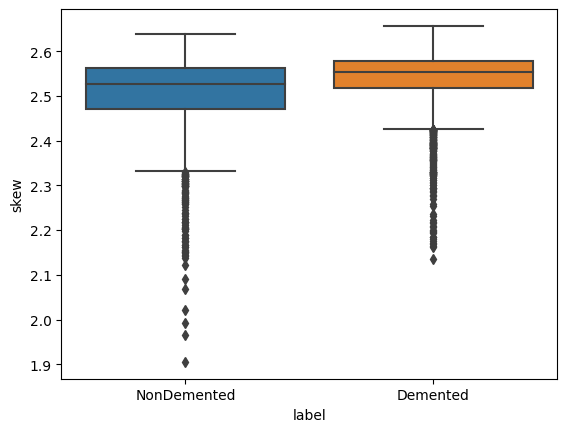

In [21]:
sns.boxplot(image_stats, y='skew', x='label')


## Conclusion:
By looking at the scatter plots and box charts, we can observe that the severity of dementia increases with increase in the skew of the images, and decreases with increase in the mean and standard deviation of the images. For high mean and standard deviation of the Brain MRI Images, chances of having dementia is low. Having low skew of the images also ensures negative dementia.